In [1]:
# install.packages(c('ModelMetrics', 'Metrics', 'pROC', 'caret', 
#                   'randomForest', 'raster', 'dplyr', 'foreign', 
#                   'maptools', 'randomForest', 'rgdal', 'readxl', 
#                   'glue', 'caret', 'ModelMetrics', 'Metrics', 
#                   'pROC', 'raster', 'plyr', 'ggplot2', 'sp'))

Warning message in install.packages(c("ModelMetrics", "Metrics", "pROC", "caret", :
“installation of package ‘raster’ had non-zero exit status”Warning message in install.packages(c("ModelMetrics", "Metrics", "pROC", "caret", :
“installation of package ‘dplyr’ had non-zero exit status”Warning message in install.packages(c("ModelMetrics", "Metrics", "pROC", "caret", :
“installation of package ‘rgdal’ had non-zero exit status”Warning message in install.packages(c("ModelMetrics", "Metrics", "pROC", "caret", :
“installation of package ‘caret’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [1]:
library(plyr)
library(dplyr)

library(sp)
library(glue)

library(foreign)
library(maptools)
library(randomForest)
library(rgdal)
library(readxl)
library(caret)
library(ModelMetrics)
library(Metrics)
library(pROC)
library(raster)
#library(magrittr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

rgdal: version: 1.4-3, (SVN revision 828)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.1, released 2

In [2]:
g <- glue

In [3]:
source('R/order_pca.R')

# Load data

In [7]:
data_dir = 'data_100m'

points_df <- read.csv('{data_dir}/points.csv'%>%g, row.names="point_index")
points_df <- SpatialPointsDataFrame(points_df[c("x", "y")], points_df)
points_df$veg_agg <- points_df$veg_agg %>%  as.factor
points_df$veg <- points_df$veg %>% as.factor

fires_df <- read.csv('{data_dir}/fires.csv'%>%g)
fires_df <- SpatialPointsDataFrame(fires_df[c("x", "y")], fires_df)

In [8]:
points_df %>% str

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	492280 obs. of  13 variables:
  .. ..$ row    : int [1:492280] 29 29 29 29 29 29 29 30 30 30 ...
  .. ..$ col    : int [1:492280] 1159 1160 1161 1162 1176 1177 1178 1158 1159 1160 ...
  .. ..$ x      : num [1:492280] 1494778 1494878 1494978 1495078 1496478 ...
  .. ..$ y      : num [1:492280] 4946884 4946884 4946884 4946884 4946884 ...
  .. ..$ dem    : num [1:492280] 543 541 537 541 663 ...
  .. ..$ slope  : num [1:492280] 24.3 22.2 18.3 16.1 20.9 ...
  .. ..$ north  : num [1:492280] -0.999 -1 -0.998 -0.967 -0.898 ...
  .. ..$ east   : num [1:492280] 0.0376 0.0291 -0.0667 -0.2565 0.4396 ...
  .. ..$ veg    : Factor w/ 64 levels "0","1","2","5",..: 47 47 47 47 29 29 29 47 47 47 ...
  .. ..$ veg_agg: Factor w/ 8 levels "21","22","23",..: 5 5 5 5 6 6 6 5 5 5 ...
  .. ..$ urban_d: num [1:492280] 707 781 849 900 1552 ...
  .. ..$ roads_d: num [1:492280] 1000 1000 1000 1005 1300 ...
  .. ..$ cr

In [9]:
fires_df %>% str

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	106919 obs. of  8 variables:
  .. ..$ point_index: int [1:106919] 1709 1878 1879 2049 2050 2142 2143 2144 2239 2240 ...
  .. ..$ x          : num [1:106919] 1500478 1499378 1499478 1498278 1498378 ...
  .. ..$ y          : num [1:106919] 4943884 4943684 4943684 4943484 4943484 ...
  .. ..$ fire_index : int [1:106919] 8210 7692 7692 1524 1524 1524 1524 1524 1524 1524 ...
  .. ..$ data       : Factor w/ 3014 levels "1997-01-03","1997-01-09",..: 2988 2795 2795 404 404 404 404 404 404 404 ...
  .. ..$ anno       : int [1:106919] 2017 2016 2016 1999 1999 1999 1999 1999 1999 1999 ...
  .. ..$ stagione   : int [1:106919] 2 2 2 1 1 1 1 1 1 1 ...
  .. ..$ area_ha    : num [1:106919] 0.00789 0.03127 0.03127 7.07098 7.07098 ...
  ..@ coords.nrs : num(0) 
  ..@ coords     : num [1:106919, 1:2] 1500478 1499378 1499478 1498278 1498378 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : NULL
  .. ..

# Filter out fires by season and years

In [10]:
build_dataset <- function(points_df, fires_df, season=NULL, year=NULL){
    # selects fires by year and season, 
    # creates a dataset from points adding the column fire according
    
    sel_fires_df <- fires_df
    if(!is.null(season)){
        sel_fires_df <- sel_fires_df %>% subset((.$stagione==season))
    }
    if(!is.null(year)){
        sel_fires_df <- sel_fires_df %>% subset(.$anno<=year)
    }
    fire_points <- sel_fires_df$point_index    
    presences_df <- points_df[fire_points, ]
    absences_df <- points_df[-fire_points, ]

    presences_df$fire = 1
    absences_df$fire = 0
    
    dataset <- rbind(presences_df, absences_df)
    dataset$fire <- dataset$fire %>% as.factor
    return(dataset)
}


In [11]:
season <- 1
year <- 2013
sample_frac = 0.1

dataset <- build_dataset(points_df, fires_df, season, year)
data_xy <- dataset[c("x", "y")]

# Geographical splitting of test and train

In [12]:
box_dimension <- 5000

In [13]:
create_spatial_grid <- function(points_df, box_dimension){
    ### define SpatialGrid object
    bb <- bbox(points_df)

    cs <- c(box_dimension, box_dimension) # cell size 
    cc <- bb[, 1] + (cs/2)  # cell offset

    cd <- ceiling(diff(t(bb))/cs)  # number of cells per direction
    grd <- GridTopology(cellcentre.offset=cc, cellsize=cs, cells.dim=cd)
    
    sp_grd <- SpatialGridDataFrame(grd, data=data.frame(id=1:prod(cd)))
    # print(points_df)

    over_boxes <- over(points_df, sp_grd)
    
    return(over_boxes)
}

select_pseudo_absences <- function(dataset, presence_index){
    pres <- dataset %>% 
            subset(presence_index)
    
    print("Selecting {nrow(pres)} elements as pseudo-absences"%>%g)
    
    abs <- dataset %>%  
            subset(!presence_index) %>% 
            sample_n(nrow(pres))
    
    pseudo_absences_dataset <- rbind(pres, abs)
    return(pseudo_absences_dataset)
}

In [14]:
# define a spatial grid over the dataset
over_boxes <- create_spatial_grid(dataset, box_dimension)

dataset$box <- over_boxes$id

# create the folds
unique_boxes <- dataset$box %>% unique
folds <- replicate(10, 
    unique_boxes %>% sample(length(.)/10, replace = TRUE)
)


In [19]:
columns = c("fire", "slope","dem", "north", "east", "veg_agg", "urban_d", "roads_d", "crops_d")

list_of_RF = c()

# Loop over folds
for(col in 1:ncol(folds)) {
    print("fold: {col}"%>%g)
    
    fold <- folds[, col]
    
    TS_dataset <- dataset %>% subset(.$box %in% fold) 
    TS_dataset <- TS_dataset[columns] %>% as.data.frame
    
    TR_dataset <- dataset %>% subset(!(.$box %in% fold))
    TR_dataset <- TR_dataset[columns] %>% as.data.frame

    TR <- select_pseudo_absences(TR_dataset, TR_dataset$fire==1)
    TS <- select_pseudo_absences(TS_dataset, TS_dataset$fire==1)    

    TR$fire <- TR$fire %>% as.factor
    TS$fire <- TS$fire %>% as.factor
    
    RF <- randomForest(fire~., TR, type="prob", importance=TRUE, do.trace=TRUE, mtry=4)
    
    list_of_RF %<>% append(c(RF, TR, TS)) 
    
}

# Predictive map


In [24]:
pred_ffW<-predict(object=RF_ffW, newdata=TRW_var, type="prob")

XY_predffW<-cbind(data_xy,pred_ffW)

write.dbf(XY_predffW, "RF_FFW.dbf")
colnames(XY_predffW)[1] <-"x"
colnames(XY_predffW)[2] <-"y"
colnames(XY_predffW)[4] <-"z"

In [32]:
e <- extent(XY_predffW[,1:2])
r <- raster(e, resolution=100)
RF_FFW_raster <- rasterize(XY_predffW[, 1:2], r, XY_predffW[,4])

writeRaster(RF_FFW_raster,"RF_FFW.tif", overwrite=TRUE)

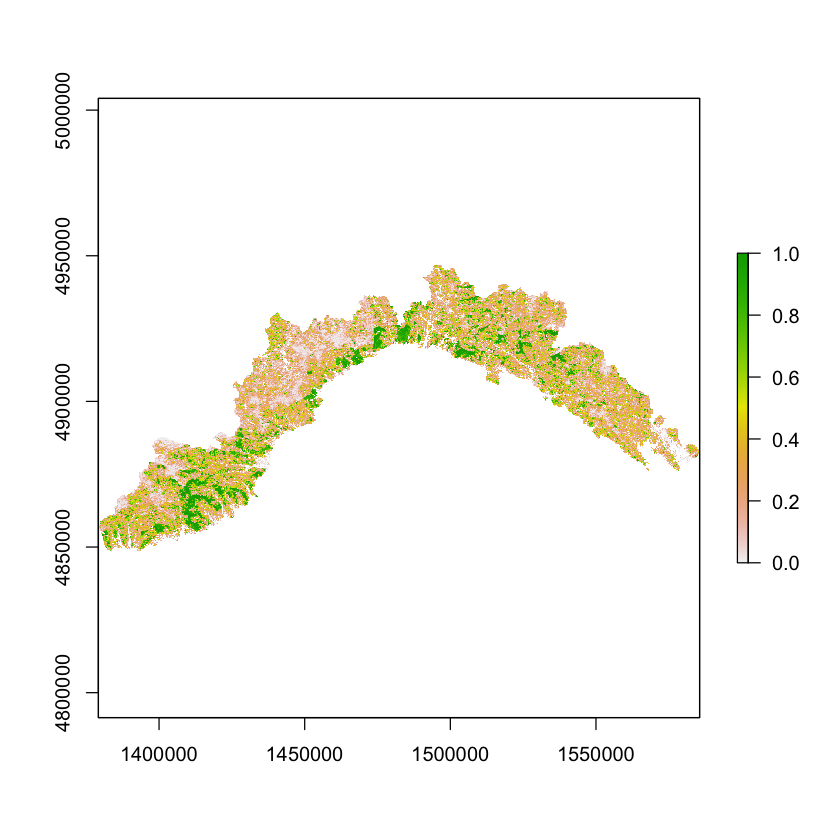

In [33]:
plot(RF_FFW_raster)

In [ ]:
#Summer
TR_pres_S<-subset(pres, (pres$anno<2013) & (pres$stagione==2))
TR_abs_S<-sample_n(abs, nrow(TR_pres_S))
TR_ff_S<-union(TR_abs_S, TR_pres_S)

TS_pres_S<-subset(pres, (pres$anno>=2013) & (pres$stagione==2))
TS_abs_S<-sample_n(abs, nrow(TS_pres_S))
TS_ff_S<-union(TS_abs_S, TS_pres_S)


TRS<-TR_ff_S[c("fire", "slope","dem", "north", "east", "veg_new", "urban_d", "roads_d", "crops_d")]

TRS_var<-dataorig [c("slope","dem", "north", "east", "veg_new", "urban_d", "roads_d", "crops_d")]


RF_ffS<-randomForest(fire~., TRS, type="prob", importance=TRUE, do.trace=TRUE, mtry=4)
print(RF_ffS)
plot(RF_ffS)
varImpPlot((RF_ffS))

# par_Va<-partialPlot(RF_ffS, TRS, veg_new, "1")
par_Va<-partialPlot(RF_ffS, TRS, veg_new, "1", n.pt=length(veg_order))
veg_importance = veg_order[order((par_Va$y))]


write.dbf(par_Va, "par_Var_new.dbf")

par_dem<-partialPlot(RF_ffS, TRS, dem, "1")


# Predictive map
pred_ffS<-predict(object=RF_ffS, newdata=TRS_var, type="prob")

XY_predffS<-cbind(data_xy,pred_ffS)

write.dbf(XY_predffS, "RF_FFS.dbf")
colnames(XY_predffS)[1] <-"x"
colnames(XY_predffS)[2] <-"y"
colnames(XY_predffS)[4] <-"z"
e <- extent(XY_predffS[,1:2])
r <- raster(e, resolution=100)
RF_FFS_raster <- rasterize(XY_predffS[, 1:2], r, XY_predffS[,4])

writeRaster(RF_FFS_raster,"RF_FFS.tif", overwrite=TRUE)

# ROC courve and AUC estimation

In [ ]:


RFS_roc<-roc(TRS$fire, RF_ffS$votes[,2])

auc(RFS_roc)

pred_TSS <- predict(object = RF_ffS,
                    newdata = TS_ff_S,
                    type = "prob")

TSSord_roc<-roc(TS_ff_S$fire, pred_TSS[, 2])
auc(TSSord_roc)
plot(TSSord_roc, col="red", lty=2, pty="s", add=T)